GluonCV Simple Pose on Amazon SageMaker
===================================================================
---

*Credits*: the Simple Pose training scripts used in this notebook were adapted from [GluonCV](https://gluon-cv.mxnet.io/model_zoo/pose.html#simple-pose-with-resnet) for Amazon SageMaker.


 **Learning Objectives:**

* How to train and deploy a GluonCV Pose Estimation Model on Amazon SageMaker
* How to deploy an inference pipeline model to process images using multiple Computer Vision models.

---

In this lab, we'll work with Pose Estimation: a domain within Computer Vision involving techniques that localize keypoints on objects and construct it's figure (pose). Most commonly, pose estimation is applied to humans as shown below.

We'll be learning how to train and deploy a **Simple Pose**[$^{[1]}$](#References) model using Amazon SageMaker and GluonCV. Simple Pose is a simple yet effective algorithm for 2D Pose Estimation. We apply this technique to localize the joints and construct the 2D figure of people in images like in the image below.

In the industry, Pose Estimation can be applied to media analytics. For instance, Pose Estimation can be used to analyze and monitor the pose of atheletes as part of a sports performance analytics application.

---

<img src= https://dtong-ml-datasets.s3.amazonaws.com/web/images/pose-estim-dancing.gif width=50% align="center"/>

Step 1: Prepare our Development Environment
==============================

This notebook was designed to run on Amazon SageMaker. You should run this Notebook within one of the provided MXNet kernels.

First, we need to install and import dependencies required to run GluonCV and to run visualizations. Matplotlib isn't installed by default. We'll need it for visualizations. Run the cell below.

In [ ]:
!pip install --upgrade pip
!pip install matplotlib

%matplotlib inline

---
In this notebook we run GluonCV scripts and visualizations which has dependencies on core Python data science libraries as well as the MXNet/Gluon framework.

We import and set Amazon SageMaker variables so that we can make in context API calls to Amazon SageMaker for training and hosting.

In [17]:
from __future__ import division

import time, os
from datetime import datetime

import boto3

import numpy as np
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.data.vision import transforms

import sagemaker

from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker.pipeline import PipelineModel

# This notebook will only run on MXNet version >= 1.6.0. The GluonCV pose estimation script
# is dependent on MXNet >= 1.6.0 and GluonCV >= 0.8.0
FRAMEWORK_VERSION = "1.6.0"
PYTHON_VERSION = "py3"
SOURCE_DIR = '../scripts/simple-pose'

runtime = boto3.client(service_name='runtime.sagemaker')
sagemaker_client = boto3.client('sagemaker')

session = sagemaker.Session()
role = sagemaker.get_execution_role()

---
GluonCV isn't currently pre-installed on Amazon SageMaker MXNet environments. However, most of the dependencies required by GluonCV have already packaged into the kernels.

We simply need to ensure a compatible MXNet version is installed and install the GluonCV libraries. MXNet dependencies are GPU dependent, so we'll check for the presence of GPU devices on your instances you're using.

In [5]:
USE_GPU = True
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = mx.gpu(0)
    print('GPU device is available')
except:
    ctx = mx.cpu()
    USE_GPU = False
    print('Using CPU on local machine. GPU device was not detected')

GPU device is available


---
### Install GluonCV


The Simple Pose algorithm has dependencies on MXNet 1.6.0+. We'll need to upgrade MXNet accordingly and install a compatible version of GluonCV.

The script below asssess your local environment and then identifies and installs the required libraries.

In [6]:
GLUONCV_COMPATIBILITY = {
    "1.5.0":"0.6.0",
    "1.5.1":"0.6.0",
    "1.6.0":"0.8.0"
}
start = time.time()

if mx.__version__ < FRAMEWORK_VERSION : 
    if USE_GPU :
        cmd = 'pip install mxnet-cu101mkl=={} --upgrade'.format(FRAMEWORK_VERSION)
    else :
        cmd ='pip install mxnet-mkl=={} --upgrade'.format(FRAMEWORK_VERSION)

    print("Changing MXNet: {}".format(cmd))
    os.system(cmd)

cmd = "pip install gluoncv=={} --upgrade".format(GLUONCV_COMPATIBILITY[FRAMEWORK_VERSION])
print("Install GluonCV: {}".format(cmd))
os.system(cmd)

end = time.time()

print("GluonCV dependencies were installed in {:3f} seconds.".format(end-start))

Install GluonCV: pip install gluoncv==0.8.0 --upgrade
GluonCV dependencies were installed in 2.517129 seconds.


---
You should be able to import GluonCV now. If not, restart your kernel and try again.

In [7]:
import gluoncv as gcv
from gluoncv import utils

### Prepare COCO datasets
---

<img src=http://cocodataset.org/images/coco-logo.png width=20% align="left"/>

[COCO](<http://cocodataset.org/#home>) is a large-scale object detection, segmentation, and captioning datasetself. It contains annotations for keypoints, which can be used for training pose estimation.

The dataset is large. We'll download a partial dataset for learning purposes.

---

We need to transfer the dataset to S3, so that our SageMaker Training job can access the dataset. Provide a S3 bucket URI for this purpose by replacing *\<<YOUR BUCKET\>>* below. The IAM role attached to this environment should have read and write access to this bucket. 

In [10]:
##eg. s3://dtongma-ml-datasets-us-west-2/pose-estimation-workshop/coco/sample
#TRAINING_DATA = '<<YOUR BUCKET>>'
TRAINING_DATA = 's3://dtongma-ml-datasets-us-west-2/pose-estimation-workshop/coco/sample3'

---
Run the cell below to download a partial dataset and transfer it to your S3 bucket. This usually takes 5-10 minutes to complete.

In [30]:
DOWNLOAD_SCRIPT = "../utils/dl_coco_partial.py"
DOWNLOAD_DIR = "../datasets/coco"

start = time.time()

os.system("python {} --download-dir {}".format(DOWNLOAD_SCRIPT, DOWNLOAD_DIR))

#we're using the validation set for learning purposes. It's manageable at 1/10th the size of the training set.
os.system("aws s3 sync {} {}".format(os.path.join(DOWNLOAD_DIR,"val2017"), 
                                      os.path.join(TRAINING_DATA,"val2017")))
           
os.system("rm {}".format(os.path.join(DOWNLOAD_DIR,"annotations","person_keypoints_train2017.json")))
os.system("mv {} {}".format(os.path.join(DOWNLOAD_DIR,"annotations","person_keypoints_val2017.json"),
                            os.path.join(DOWNLOAD_DIR,"annotations","person_keypoints_train2017.json")))

os.system("aws s3 cp {} {}".format(os.path.join(DOWNLOAD_DIR,"annotations","person_keypoints_train2017.json"), 
                                      os.path.join(TRAINING_DATA,"annotations","person_keypoints_train2017.json")))
          
end = time.time()

print("Transferred partial COCO dataset in {:3f} seconds.".format(end-start))

Transferred partial COCO dataset in 66.536092 seconds.


Step 2: Model Training
==============================

----
Next, we'll learn how to train a Simple Pose model. We'll go through the typical experimentation process. We start by prototyping and training the model locally.

Let's take a look at the training script. The original script was modified so that the model directories, training and test data directories are retrieved from the SageMaker container environment variables.

For instance, *if args.model_dir == None : args.model_dir = os.environ['SM_MODEL_DIR']*   

In [ ]:
!pygmentize $SOURCE_DIR/simple-pose-train.py

### Local Prototyping
---

You can run the training script locally. Note that without GPU, training the model from scratch would take prohibitively long.

In [ ]:
!mkdir ./models/simple-pose
!python ../scripts/simple-pose/simple-pose-train.py \
--model-dir ./models/simple-pose \
--train ../datasets/coco \
--lr 0.000001 \
--num-joints 17 \
--use-pretrained True \
--local True \
--model simple_pose_resnet18_v1b \
--num-gpus 1 \
--num-workers 1 \
--save-format 'symbolic' \
--batch-size 4 --num-epochs 1 --mode hybrid

### Scale Training
---

The actual COCO dataset is large and the Pose Estimation model can take a long time to train. We can scale our training process by using Amazon SageMaker training services. We have the abilty to train on multi-GPU, use distributed training as well as hyperparamter tuning automation.

In the following section, we'll walk you through the process of launching a remote training job.


#### Bring Your Own MXNet GluonCV Script

---

One of the main benefits of leveraging the "Bring-Your-Own-Script" (BYOS) integration strategy is that it reduces alot of heavy-lifting compared to the alternative. For instance, if you want to integrate a custom algorithm in R with Amazon SageMaker, it is feasible. However, at this point in time, the BYOS integration option doesn't supported in R. Integrating your R algorithm would require you to build  an Amazon SageMaker compatible container to house your custom [algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html).

MXNet, however, supports BYOS--Amazon SageMaker provides and maintains MXNet containers natively. We'll be using the SageMaker managed MXNet containers.

---
#### Installing Dependencies on SageMaker Managed Containers

Sometimes we may want to install or upgrade select depedencies. You have the option of creating your own SageMaker compatible container by using the MXNet container as a base, or update the dependencies at launch time by using [requirements.txt](https://pip.pypa.io/en/stable/user_guide/#id15).

DevOps best practices recommend building your own container. Requirements.txt is often ideal for development. You can apply minor updates quickly to support rapid prototyping. We'll be using the latter strategy.

---
Below are some helper scripts to set requirements.txt for your target environment and also provide suggestions for GPU dependent configurations.

In [34]:
# sample selection of SageMaker instances and available GPUs
INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.p3.8xlarge':4,
    'ml.c5.4xlarge':0,
    'ml.c5.2xlarge':0,
    'ml.c5.xlarge':0,
    'ml.g4dn.xlarge':1
}

def set_requirements_text(gpu_train=True, framework_v=FRAMEWORK_VERSION) :
    
    req_file = "{}/requirements.txt".format(SOURCE_DIR)
    with open(req_file, "r+") as f:
        data = f.read()
        f.seek(0)
        f.write("gluoncv=={} \n".format(GLUONCV_COMPATIBILITY[framework_v]))
        f.write("opencv-python==3.3.0.9")
        f.truncate()
        
    !pygmentize $SOURCE_DIR/requirements.txt

def environment_device_config(instance_selection, acceleration_type=None, framework_v=FRAMEWORK_VERSION) :
    
    USE_GPU = (INSTANCE_GPUS[instance_selection] > 0)

    n_gpus = INSTANCE_GPUS[instance_selection]

    print('Set requirements.txt:') 
    print('-----------------------------------')
    set_requirements_text(USE_GPU,framework_v)
    print('-----------------------------------')
    
    config={
        "num_gpus":n_gpus,
        "batch_size_range": [1 if USE_GPU else 1, 16 if USE_GPU else 64]
    }
    
    print('You have selected {}{}, which will utilize {}.'.format(instance_selection, 
                                                                '' if acceleration_type == None else " with EIA ({})".format(acceleration_type),
                                                                'GPU' if USE_GPU else 'CPU' if acceleration_type == None else "EIA"))
    
    print('Recommended training configurations: {}'.format(config))
    
    return config

---
Let's set our INSTANCE_TYPE and generate our requirements.txt and set the parameters for our Simple Pose training job.

In [35]:
INSTANCE_TYPE = 'ml.p3.2xlarge'
config = environment_device_config(INSTANCE_TYPE)

BASE_JOB_NAME='dylantong-pose-training'
NUM_JOINTS = 17
MX_MODE = "symbolic"

params = {
    'lr': 0.000001, 
    'num-joints': NUM_JOINTS, 
    'use-pretrained': True,
    'num-epochs': 1,
    'model': 'simple_pose_resnet18_v1b',
    'num-gpus' : config["num_gpus"],
    'batch-size' : int(config["batch_size_range"][1]/2),
    'mode': 'hybrid',
    'save-format': MX_MODE,
    'j': 3
}

print()
print("Using params: {}".format(params))

Set requirements.txt:
-----------------------------------
gluoncv==0.8.0 
opencv-python==3.3.0.9
-----------------------------------
You have selected ml.p3.2xlarge, which will utilize GPU.
Recommended training configurations: {'num_gpus': 1, 'batch_size_range': [1, 16]}

Using params: {'lr': 1e-06, 'num-joints': 17, 'use-pretrained': True, 'num-epochs': 1, 'model': 'simple_pose_resnet18_v1b', 'num-gpus': 1, 'batch-size': 8, 'mode': 'hybrid', 'save-format': 'symbolic', 'j': 3}


#### Configure and Run Your SageMaker Estimator
---

Next we create a SageMaker MXNet Estimator. This class escapsulates a MXNet training job: security, infrastructure, data, scripts and parameters.

In [36]:
pose_estimator = MXNet(entry_point='simple-pose-train.py',
                        role=role,
                        source_dir=SOURCE_DIR,
                        framework_version=FRAMEWORK_VERSION,
                        py_version=PYTHON_VERSION,
                        train_instance_count=1,
                        train_instance_type=INSTANCE_TYPE,
                        sagemaker_session=sagemaker.Session(),
                        base_job_name=BASE_JOB_NAME,
                        hyperparameters=params)

---

By calling the fit() method, we specify the S3 location of our training data and launch the remote training job. For the sake of demonstration, we load a pre-trained model and only one epoch on a subset of the COCO data. This will take 5-10 minutes to complete.

Your can train your own simple pose model from the ground up using the same process. Simply provide a different annotated dataset and run a hyperparameter tuning job.


In [ ]:
pose_estimator.fit({'train':TRAINING_DATA})

# Step 3: Deploy Model
---

Now that we have a trained Simple Pose model, we can deploy a SageMaker model serving endpoint to serve real-time predictions.

In order to host our model on Amazon SageMaker, we have to implement an interface. Let's take a look at the model serving script.


In [ ]:
!pygmentize $SOURCE_DIR/'simple-pose-inference.py'

---

Our Pose Estimation model isn't design to process raw images on it's own. Notice that the input (input_fn) expects bounding boxes, scores and class ids. Where have we seen this from? 

It's the output from an object detection model. Our pose estimator depends on an object detector to provide bounding box predictions for people in an image. It further processes the raw image with the localization data points to produce key points and the 2D pose of the detected people.

For the sake of demonstration, I've provided a model serving script for a pre-trained COCO YOLOv3 model. Refer to the previous lab, Lab3, on how to build, train and deploy your own custom YOLOv3 model.

In [ ]:
!pygmentize $SOURCE_DIR/'yolov3-inference.py'

---
### Amazon SageMaker Inference Pipelines

Amazon SageMaker provides a feature for chaining hosted models to create inference pipelines as a single managed model entity. 

We're going to use this feature create a real-time inference pipeline that consists of a YOLOv3 model that pipes it's output into our Simple Pose model


In [41]:
# 8/28/2020 MXNET 1.6 containers don't have support for elastic inference. Using MXNet 1.5.1 for serving temporarily.
#INFERENCE_MXNET_VER = '1.5.1'
#ACCELERATION_TYPE = 'ml.eia1.medium'
INFERENCE_MXNET_VER = '1.6.0'
ACCELERATION_TYPE = None

INSTANCE_TYPE = 'ml.c5.4xlarge'
#INSTANCE_TYPE = 'ml.p3.2xlarge'

config = environment_device_config(INSTANCE_TYPE, ACCELERATION_TYPE, INFERENCE_MXNET_VER)

USE_GPU = config['num_gpus'] > 0
USE_EIA = (ACCELERATION_TYPE is not None) and not USE_GPU

IMG_WIDTH = 512
#IMG_WIDTH = 180

MX_MODE = "symbolic"
SYM_FILE_NAME = "simple-pose-gcv-symbol.json"
PARAM_FILE_NAME = "simple-pose-gcv-0000.params"



Set requirements.txt:
-----------------------------------
gluoncv==0.8.0 
opencv-python==3.3.0.9
-----------------------------------
You have selected ml.c5.4xlarge, which will utilize CPU.
Recommended training configurations: {'num_gpus': 0, 'batch_size_range': [1, 64]}


#### Create the Inference Pipeline
---

First, we create a MXNetModel object for our YOLOv3 object and register it with Amazon SageMaker.


In [42]:
env_vars = {"SAGEMAKER_MODEL_SERVER_TIMEOUT":"3600",
            "USE_GPU": str(int(USE_GPU)),
            "USE_EIA": str(int(USE_EIA)),
            "IMG_WIDTH": str(IMG_WIDTH)}

yolo_model = MXNetModel(model_data = "s3://dtong-public-fileshare/models/yolov3/symbolic/model.tar.gz",
                        role=role,
                        framework_version=INFERENCE_MXNET_VER,
                        py_version=PYTHON_VERSION,
                        entry_point='yolov3-inference.py',
                        env = env_vars,
                        source_dir=SOURCE_DIR)

yolo_model.sagemaker_session = session
container_def = yolo_model.prepare_container_def(instance_type=INSTANCE_TYPE)
session.create_model("pose-estimator-pipeline-yolov3", role, container_def)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Using already existing model: pose-estimator-pipeline-yolov3


'pose-estimator-pipeline-yolov3'

---

Next, we do the same for our Simple Pose model.


In [43]:
env_vars = {"SAGEMAKER_MODEL_SERVER_TIMEOUT":"3600",
            "SYM_FILE_NAME":SYM_FILE_NAME,
            "PARAM_FILE_NAME":PARAM_FILE_NAME,
            "MX_MODE": MX_MODE,
            "USE_GPU": str(int(USE_GPU)),
            "USE_EIA": str(int(USE_EIA)),
            "IMG_WIDTH": str(IMG_WIDTH)}
                              
pose_model = MXNetModel(model_data = pose_estimator.model_data,
                        role=role,
                        framework_version=INFERENCE_MXNET_VER,
                        py_version=PYTHON_VERSION,
                        entry_point='simple-pose-inference.py',
                        env = env_vars,
                        source_dir=SOURCE_DIR)

pose_model.sagemaker_session = session
container_def = pose_model.prepare_container_def(instance_type=INSTANCE_TYPE)
session.create_model("pose-estimator-pipeline-simple-pose", role, container_def)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Using already existing model: pose-estimator-pipeline-simple-pose


'pose-estimator-pipeline-simple-pose'

---

Now we can create a PipelineModel. We specify the pipeline order by passing an ordered list: *models=[yolo_model, pose_model]*

In [44]:
pose_inf_pipeline = PipelineModel(name='pose-inf-pipeline',
                                  role=role,
                                  sagemaker_session=session,                                  models=[yolo_model, pose_model])

#### Deploy the Inference Pipeline Model
---

Finally, we can deploy our inference pipeline by providing our final configurations--the infrastructure specifications--and calling deploy().



In [ ]:
RT_PIPELINE_EP_NAME = 'simple-pose-inf-ep-{}'.format(datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
print('endpoint name: {}'.format(RT_PIPELINE_EP_NAME))

start = time.time()
pose_pipe_ep = pose_inf_pipeline.deploy(instance_type=INSTANCE_TYPE,
                                        initial_instance_count = 1,
                                        endpoint_name= RT_PIPELINE_EP_NAME)
end = time.time()

print("Endpoint was deployed in {:3f} seconds.".format(end-start))

# Step 4: Test Model Endpoint
---

The script below sends three raw images from the COCO dataset over to our endpoint. Our inference endpoint will detect the people in the image and generate a 2D pose.

We use high-level visualization methods provided by GluonCV to visualize the predicted bounding boxes and human figures.


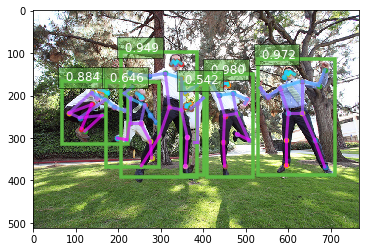

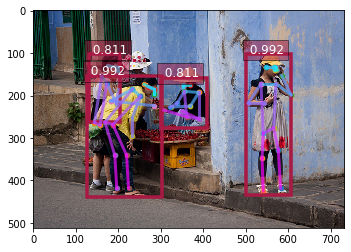

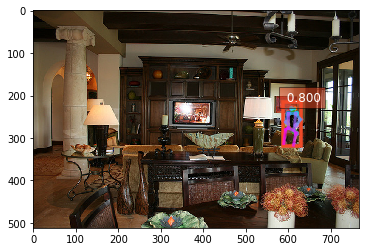

In [46]:
CID_END_OFFSET = 100
SCORE_END_OFFSET = 200
BBOX_END_OFFSET = 600
Y = 100
N_SCORES = 1
N_CID = 1
N_BBOX_POINTS = 4

JOINTS = 17
IMG_DIMS = 2

USE_GPU = 0
USE_EIA = 0

def generate_request_payload(img_loc) :

    with open(img_loc, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        
    return b

def parse_response_payload(resp) :
    
    stacked_tensors = np.frombuffer(resp, dtype="float32")
    t= np.split(stacked_tensors,[CID_END_OFFSET,SCORE_END_OFFSET,BBOX_END_OFFSET])

    cid= mx.nd.array(t[0].reshape(1,Y,N_SCORES))
    s= mx.nd.array(t[1].reshape(1,Y,N_CID))
    bb= mx.nd.array(t[2].reshape(1,Y,N_BBOX_POINTS))
    
    pose_data_size = int(t[3].shape[0])
    split = int(pose_data_size*2/3)
    
    kp = t[3][0:split].reshape(-1,JOINTS,IMG_DIMS)
    s2= t[3][split:pose_data_size].reshape(-1,JOINTS,1)

    return (cid,s,bb,kp,s2)

IMGS = ['val2017/000000296657.jpg','val2017/000000323263.jpg','val2017/000000440475.jpg']

def test_endpoint(img_file_list) :
    
    for img in img_file_list :

        b = generate_request_payload(os.path.join(DOWNLOAD_DIR,img))
        
        response = runtime.invoke_endpoint(EndpointName= RT_PIPELINE_EP_NAME,
                                           ContentType='image/jpeg',
                                           Body=b,
                                           Accept="application/x-npy")
        
        cid,s,bb,kp,s2 = parse_response_payload(response["Body"].read())

        x, img = gcv.data.transforms.presets.yolo.transform_test(mx.img.imdecode(b), IMG_WIDTH)
        
        ax = utils.viz.plot_keypoints(img, kp, s2,
                                      cid, bb, s,
                                      box_thresh=0.5, keypoint_thresh=0.2)
        plt.show()

test_endpoint(IMGS)

---
## References

.. [1] Xiao, Bin, Haiping Wu, and Yichen Wei. \
       "Simple baselines for human pose estimation and tracking." \
       Proceedings of the European Conference on Computer Vision (ECCV). 2018.
.. [2] https://github.com/Microsoft/human-pose-estimation.pytorch/issues/48
.. [3] https://github.com/PaddlePaddle/models/tree/develop/fluid/PaddleCV/human_pose_estimation#known-issues

